# Generative Adversarial Networks - Fruits

Based on [https://www.tensorflow.org/tutorials/generative/dcgan](https://www.tensorflow.org/tutorials/generative/dcgan); modified from MNIST to Fruits-360 data.

## Setup


In [22]:
## checkpoint directory for saving model weights
checkpoint_base_dir = './checkpoints'

In [23]:
## Data is stored locally in ./data folder
## No kagglehub download needed

In [24]:
import os

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def show_img_data(images, no=100, layout=(10, 10), figsize=(6, 6)):
    """Display images in a grid layout."""
    # Convert to numpy if it's a TensorFlow tensor
    if hasattr(images, 'numpy'):
        images = images.numpy()
    
    rows, cols = layout
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()
    
    for i in range(min(no, len(images), rows * cols)):
        img = images[i]
        # Handle different image formats
        if img.min() < 0:
            img = (img + 1) / 2  # Scale from [-1, 1] to [0, 1]
        img = np.clip(img, 0, 1)
        axes[i].imshow(img)
        axes[i].axis('off')
    
    # Hide any unused subplots
    for i in range(min(no, len(images), rows * cols), rows * cols):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

In [25]:
## Data is already in local ./data folder
## Contents: Training/ and Test/ directories

In [26]:
train_data_dir = './data/Training'

batch_size = 128
img_size = (32, 32)

In [27]:
train_data = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    shuffle=True,
    seed=4232,
    image_size=img_size,
    batch_size=batch_size)

FileNotFoundError: [Errno 2] No such file or directory: '/home/phigep/.cache/kagglehub/datasets/moltean/fruits/versions/76/fruits-360/Training'

In [ ]:
## put everything into a numpy array for better performance
train_x_list = [img_batch.numpy() / 255. for img_batch, _ in train_data]
train_x = np.concatenate(train_x_list)

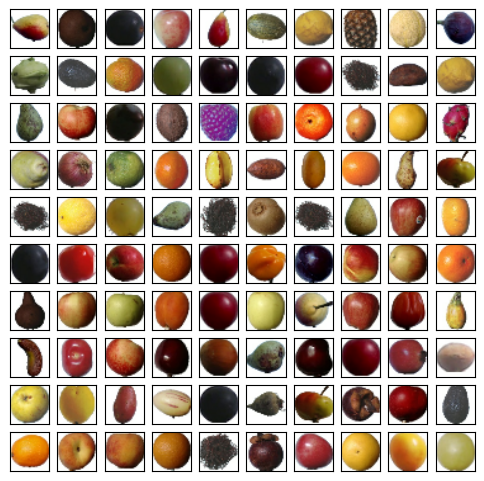

In [ ]:
show_img_data(train_x, no=100, layout=(10, 10), figsize=(6, 6))

In [ ]:
buffer_size = 60000
train_dataset = tf.data.Dataset.from_tensor_slices(train_x.reshape(train_x.shape[0], train_x.shape[1], train_x.shape[2], 3)).shuffle(buffer_size).batch(batch_size)

## Set Up Generator and Discriminator Models

In [ ]:
latent_dim = 150

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(latent_dim,))),
    model.add(tf.keras.layers.Dense(4 * 4 * 256, use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Reshape((4, 4, 256)))
    assert model.output_shape == (None, 4, 4, 256)

    model.add(tf.keras.layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 128)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2D(3, (3, 3), strides=(1, 1), padding='same', use_bias=False, activation='sigmoid'))
    assert model.output_shape == (None, 32, 32, 3)

    return model

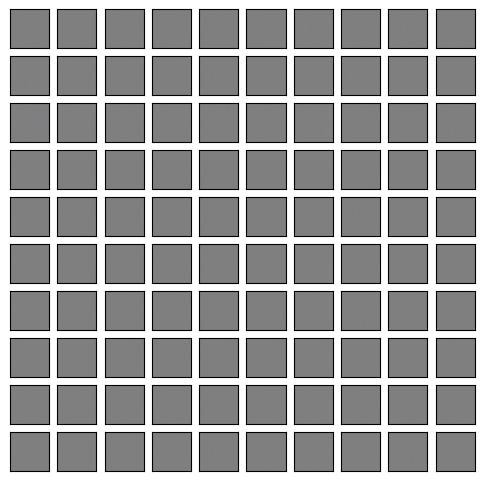

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([100, latent_dim])
generated_image = generator(noise, training=False)

show_img_data(generated_image, no=100, layout=(10, 10), figsize=(6, 6))

In [ ]:
generator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 4096)                │         614,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 4096)                │          16,384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 8, 8, 128)           │         524,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 16, 16, 128)         │         262,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 32, 32, 128)         │         262,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 3)           │           3,456 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,684,352 (6.43 MB)

 Trainable params: 1,675,392 (6.39 MB)

 Non-trainable params: 8,960 (35.00 KB)

In [ ]:
def generate_and_show_images(model, test_input):
    # Notice `training` is set to False in order to make sure that
    # all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    show_img_data(predictions, no=min(100, test_input.shape[0]), layout=(10, 10), figsize=(6, 6))

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(32, 32, 3)))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same'))
    model.add(tf.keras.layers.LeakyReLU(2))

    model.add(tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same'))
    model.add(tf.keras.layers.LeakyReLU(2))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()

In [ ]:
discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 262144)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 262144)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │         262,145 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 780,545 (2.98 MB)

 Trainable params: 780,545 (2.98 MB)

 Non-trainable params: 0 (0.00 B)

## Define Losses and Optimizers

In [ ]:
## This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1.6e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4)

In [ ]:
checkpoint_dir = os.path.join(checkpoint_base_dir, 'Fruits_training_checkpoints')
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the Training Loop

In [ ]:
no_epochs = 70
num_examples = 100

# We will reuse this seed over time
gan_seed = tf.random.normal([num_examples, latent_dim])

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)

        # show images
        print('Epoch ' + str(epoch + 1) + ' ... finished')

        # save the model every 5 epochs
        if (epoch + 1) % 5 == 0:
            generate_and_show_images(generator, gan_seed)
            checkpoint.save(file_prefix=checkpoint_prefix)

## Run Training

In [ ]:
train(train_dataset, no_epochs)

Output hidden; open in https://colab.research.google.com to view.

## Play Around with Trained Model

In [ ]:
## load latest model
latest = tf.train.latest_checkpoint(checkpoint_dir)
status = checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

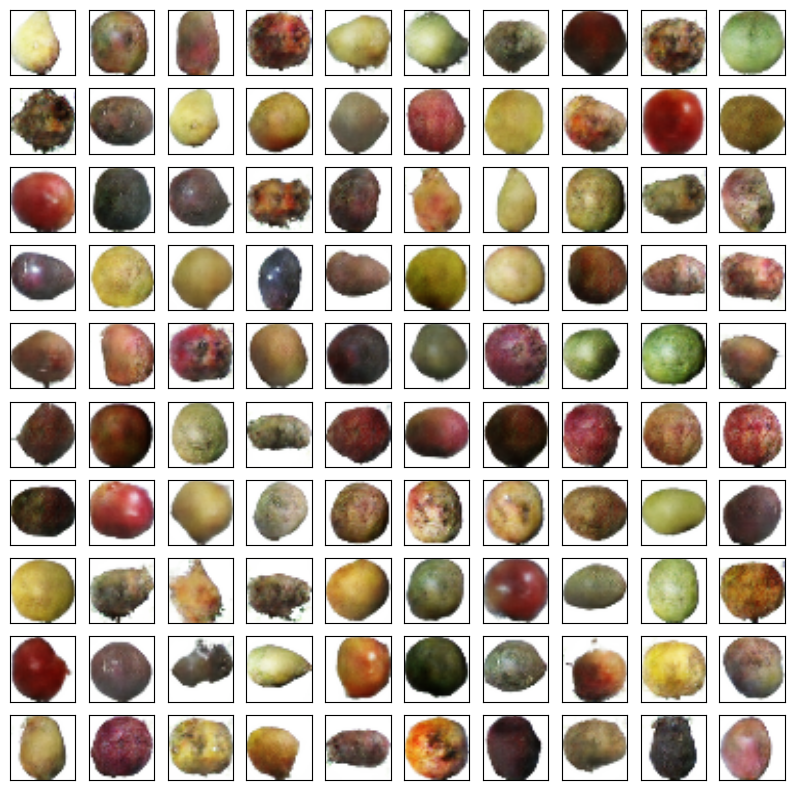

In [ ]:
## generate 100 images
noise = np.random.normal(size=[100, latent_dim])
generated_image = generator(noise, training=False)

show_img_data(generated_image, no=100, layout=(10, 10))

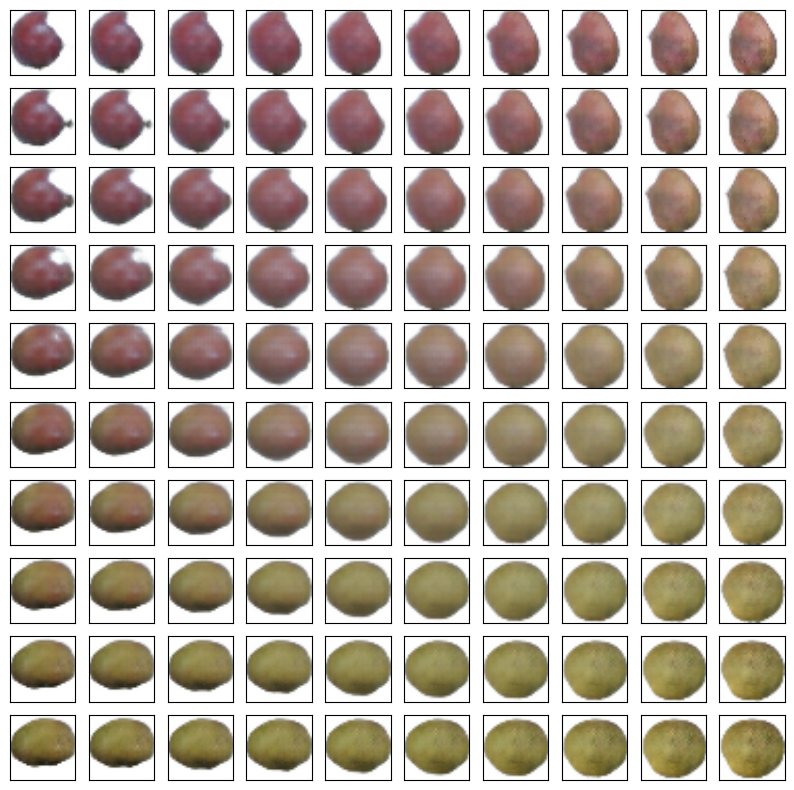

In [ ]:
n, m = 10, 10

noise = np.random.normal(size=[n * m, latent_dim], scale=0.01)
noise[:, (98, 99)] = np.array(np.meshgrid(np.linspace(-6, 6, num=n), np.linspace(-6, 6, num=m))).T.reshape(n * m, 2)
generated_image = generator(noise, training=False)

show_img_data(generated_image, no=(n * m), layout=(n, m))

In [ ]:
## Export notebook to HTML (optional)
# !jupyter nbconvert --to html "GAN_Fruits 1.ipynb"

[NbConvertApp] Converting notebook GAN_Fruits.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 4 image(s).
[NbConvertApp] Writing 2557637 bytes to GAN_Fruits.html
